<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
### <font color='blue'>Modelagem de Séries Temporais e Real-Time Analytics com Apache Spark e Databricks</font>
### <font color='blue'>Projeto 1 - Tarefa 8</font>
### <font color='blue'>Prevendo Usuários Ativos em Um Web Site</font>

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando e Organizando os Dados

In [4]:
# Carrega os dados
df_dsa = pd.read_csv("dataset.csv")
df_dsa_novos_dados = pd.read_csv("novos_dados.csv")

Vamos fazer algumas transformações nos dados para criar o modelo.

In [5]:
# Converte a coluna data para o tipo correto
df_dsa['data'] = pd.to_datetime(df_dsa.data, format = '%d-%m-%Y %H:%M')

In [6]:
# Converte a coluna data para o tipo correto
df_dsa_novos_dados['data'] = pd.to_datetime(df_dsa_novos_dados.data, format = '%d-%m-%Y %H:%M')

In [7]:
# Definimos o índice do dataset
df_dsa.index = df_dsa['data']

In [8]:
# Definimos o índice do dataset
df_dsa_novos_dados.index = df_dsa_novos_dados['data']

In [9]:
# Removemos a coluna ID, pois ela não é relevante neste caso
df_dsa.drop('id', axis = 1, inplace = True)

In [10]:
# Removemos a coluna data, pois ela não é relevante neste caso
df_dsa.drop('data', axis = 1, inplace = True)

In [11]:
# Variável target 
target = df_dsa['usuarios_ativos']

In [12]:
df_dsa.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


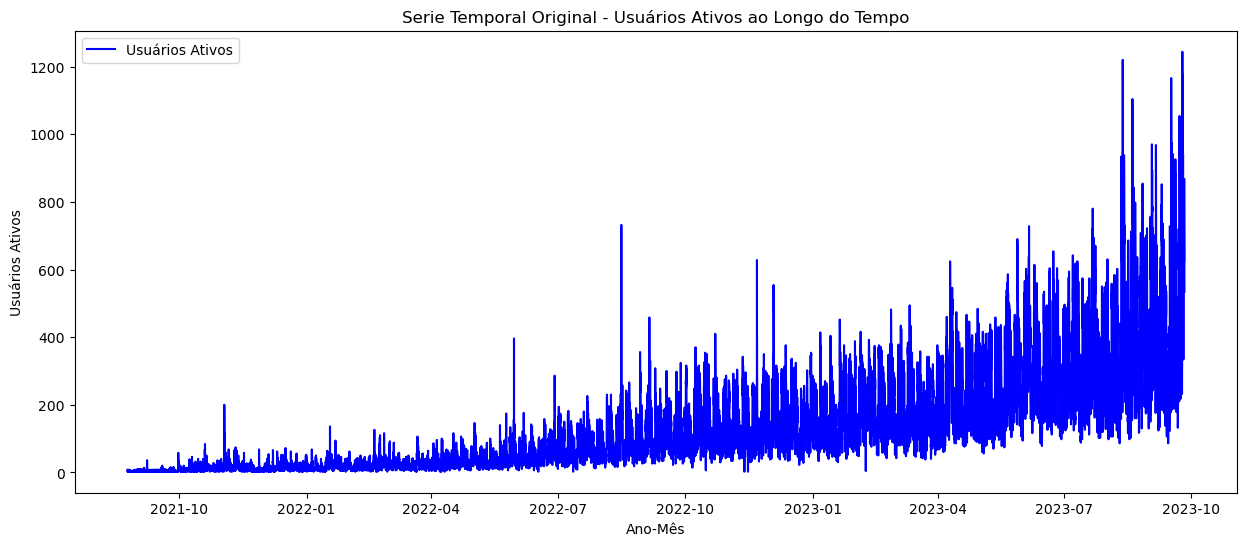

In [13]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal Original - Usuários Ativos ao Longo do Tempo")
plt.plot(target, label = "Usuários Ativos", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

Já sabemos que a série é estacionária. Vamos direto para a modelagem.

## Pré-Processamento

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo.

In [14]:
# Os dados de treino serão divididos em dados de treino e validação.
# Observe que os registros são separados em ordem cronológica.
df_treino = df_dsa.iloc[0:16057]
df_valid = df_dsa.iloc[16058:]

In [15]:
df_treino.shape

(16057, 1)

In [16]:
df_valid.shape

(2230, 1)

In [17]:
# Aplicando transformação de log (colocando os dados na mesma escala, o que é requerido pelos modelos ARIMA)
df_treino_log = np.log(df_treino['usuarios_ativos']) 

## Forecasting - Modelagem Preditiva Para Séries Temporais

Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA). 

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

### Implementando a Estratégia 4 de Forecasting - Modelo ARIMA

Para a versão 3 criamos um Modelo ARIMA.

Veja a descrição no videobook no Capítulo 6.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [18]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino_log, order = (2, 1, 0), freq = 'H')

In [19]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [20]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v3 = modelo_v3.fittedvalues

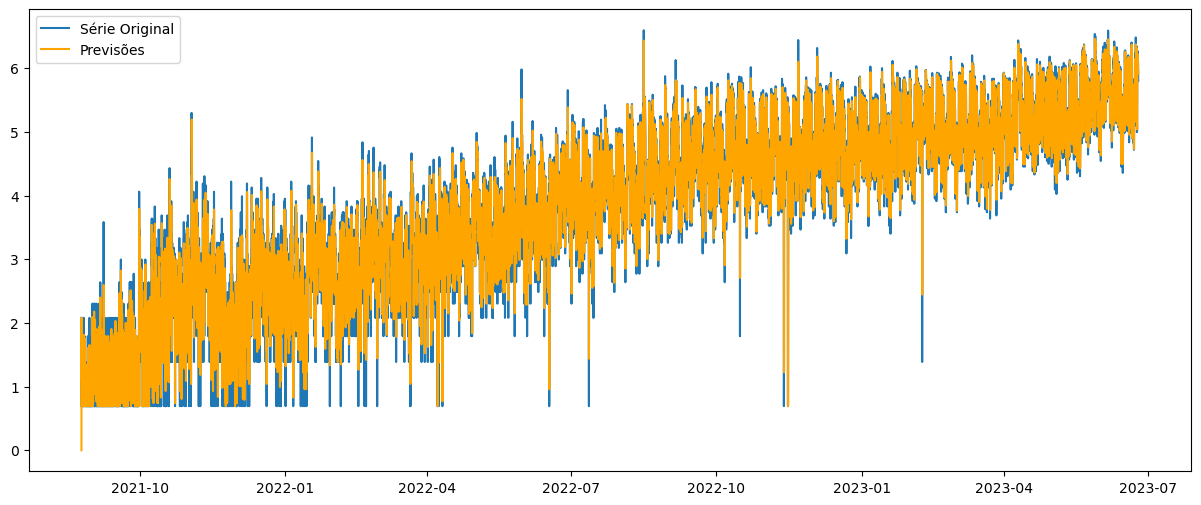

In [21]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v3, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [22]:
# Sumário do Modelo 
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        usuarios_ativos   No. Observations:                16057
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8119.356
Date:                Tue, 12 Mar 2024   AIC                          16244.711
Time:                        00:37:03   BIC                          16267.763
Sample:                    08-25-2021   HQIC                         16252.334
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3419      0.005    -68.096      0.000      -0.352      -0.332
ar.L2         -0.0695      0.006    -11.737      0.000      -0.081      -0.058
sigma2         0.1610      0.001    158.760      0.000       0.159       0.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12378.93
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aqui está uma interpretação dos resultados:

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.3419, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.0695, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.1610 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 0.95 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0 indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 16244.711. Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): 16267.763. Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): 16252.334. Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.

Vamos fazer previsões com o modelo.

Agora vamos fazer previsões com o modelo treinado usando dados de validação.

In [23]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
df_valid_log = np.log(df_valid['usuarios_ativos'])

In [24]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid_log), alpha = 0.05) 

In [25]:
df_previsoes_v3.shape

(2230,)

In [26]:
df_previsoes_v3.head()

2023-06-25 01:00:00    5.853056
2023-06-25 02:00:00    5.847868
2023-06-25 03:00:00    5.846309
2023-06-25 04:00:00    5.847203
2023-06-25 05:00:00    5.847006
Freq: H, Name: predicted_mean, dtype: float64

In [27]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v3, index = df_valid_log.index)

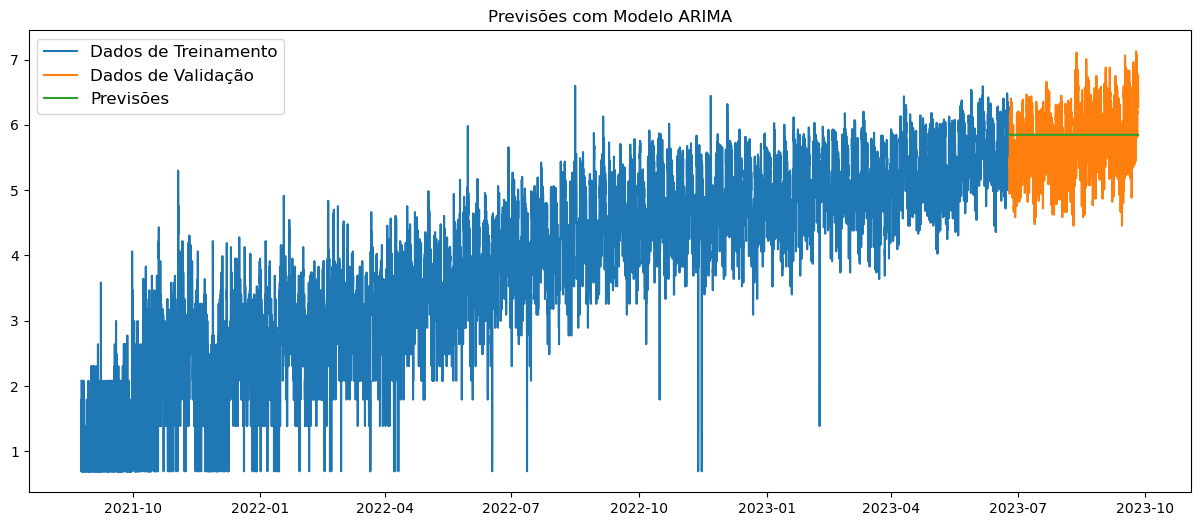

In [28]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Pronto! Temos a previsão da nossa série com o modelo criado. Vamos calcular o erro do modelo.

In [29]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [30]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [31]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5136328974922741


Opa! Reduzimos de forma considerável o erro do nosso modelo. Não é por acaso que Modelos ARIMA fazem tanto sucesso. 

Você pode estar estranhando o gráfico, mas o que fizemos foi usar a série com a transformação de log, o que muda a escala dos dados. Porém os dados são os mesmos. Daqui a pouco veremos como fazer a inversa da transformação de log.

### Implementando a Estratégia 5 de Forecasting - Modelo SARIMAX

Veja a descrição no videbook do Capítulo 6.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [32]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino_log, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

In [33]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11522D-01    |proj g|=  8.36031D-01


 This problem is unconstrained.



At iterate    1    f=  5.24014D-01    |proj g|=  2.60584D-01

At iterate    2    f=  5.20111D-01    |proj g|=  7.32641D-02

At iterate    3    f=  5.18655D-01    |proj g|=  7.31877D-02

At iterate    4    f=  5.10825D-01    |proj g|=  2.06997D-01

At iterate    5    f=  5.07025D-01    |proj g|=  1.18639D-01

At iterate    6    f=  4.99814D-01    |proj g|=  9.16718D-02

At iterate    7    f=  4.94614D-01    |proj g|=  1.75205D-01

At iterate    8    f=  4.84403D-01    |proj g|=  2.11909D-01

At iterate    9    f=  4.71473D-01    |proj g|=  5.02565D-02

At iterate   10    f=  4.68591D-01    |proj g|=  7.76723D-02

At iterate   11    f=  4.64945D-01    |proj g|=  4.54315D-02

At iterate   12    f=  4.62470D-01    |proj g|=  1.13879D-02

At iterate   13    f=  4.61038D-01    |proj g|=  2.21080D-02

At iterate   14    f=  4.60431D-01    |proj g|=  7.25344D-02

At iterate   15    f=  4.60004D-01    |proj g|=  2.04887D-02

At iterate   16    f=  4.59813D-01    |proj g|=  9.51112D-03

At iter

In [34]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v4 = modelo_v4.fittedvalues

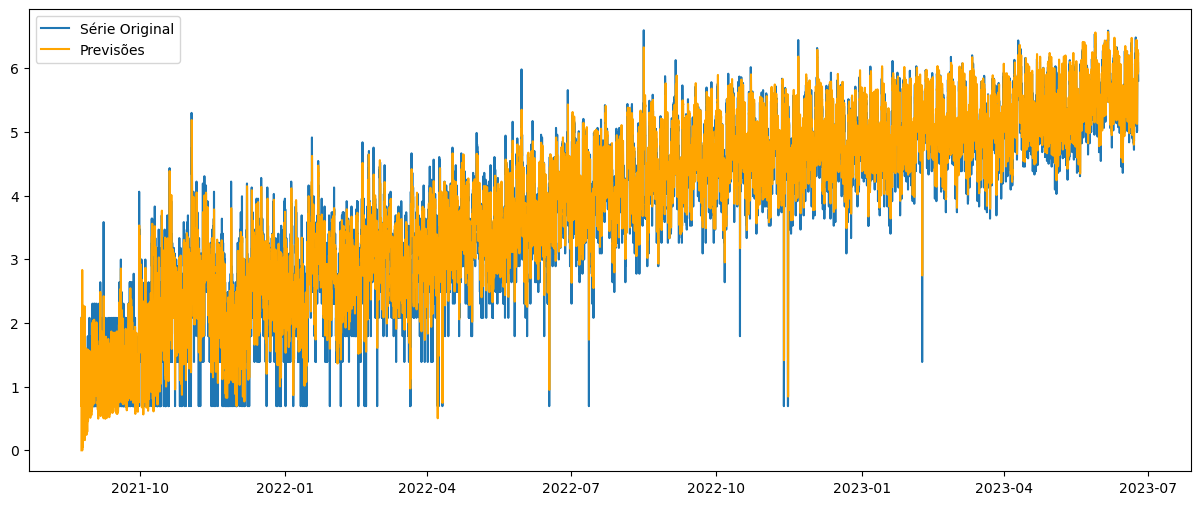

In [35]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [36]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      usuarios_ativos   No. Observations:                16057
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -7380.094
Date:                              Tue, 12 Mar 2024   AIC                          14776.188
Time:                                      00:37:19   BIC                          14837.652
Sample:                                  08-25-2021   HQIC                         14796.514
                                       - 06-25-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.005    -85.102      0.000      -0.427      -0.408
ar.L2         -0.1444      0.006    -22.494      0.000      -0.157      -0.132
ar.L3         -0.0446      0.007     -6.651      0.000      -0.058      -0.031
ar.L4         -0.0097      0.006     -1.584      0.113      -0.022       0.002
ar.L5          0.0146      0.006      2.400      0.016       0.003       0.027
ar.L6         -0.0011      0.006     -0.177      0.859      -0.013       0.011
ma.S.L12      -0.9965      0.001   -985.504      0.000      -0.998      -0.995
sigma2         0.1464      0.001    158.158      0.000       0.145       0.148
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15818.06
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Este modelo SARIMAX (Seasonal AutoRegressive Integrated Moving-Average with eXogenous variables) é um modelo de série temporal que inclui componentes sazonais. O modelo especificado é SARIMAX(6, 1, 0)x(0, 1, [1], 12), o que significa:

Parte não sazonal (ARIMA):

- AR(6): Processo autorregressivo de ordem 6.
- I(1): Diferenciação de primeira ordem.
- MA(0): Sem parte de médias móveis.

Parte sazonal:

- SAR(0): Sem componente autorregressivo sazonal.
- SI(1): Diferenciação sazonal de ordem 1.
- SMA(1): Média móvel sazonal de ordem 1.
- Período sazonal: 12 (indicando sazonalidade anual, presumivelmente mensal).

Aqui está uma interpretação dos resultados:

- Parâmetros AR: Os coeficientes dos termos autorregressivos (ar.L1 a ar.L6) mostram a relação entre o valor atual da série e seus valores anteriores. Por exemplo, o coeficiente ar.L1 é -0.4178, indicando uma relação negativa forte com o valor anterior.

- Parâmetro MA sazonal (ma.S.L12): O coeficiente de -0.9965 é muito próximo de -1, indicando uma forte relação negativa com o erro do termo sazonal anterior.

- Variância do erro (sigma2): O valor de 0.1464 indica a variância dos erros do modelo.

Testes Estatísticos:

- Ljung-Box (Q): Um valor de p (Prob(Q)) próximo de 1, como 0.99 aqui, sugere que não há evidências significativas de autocorrelação residual.
- Jarque-Bera (JB): Um valor de p (Prob(JB)) próximo de 0 indica que os resíduos não são normalmente distribuídos.
- Heteroskedasticity (H): Um valor de p (Prob(H)) próximo de 0 indica evidências de heterocedasticidade.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 14776.188. Usado para comparar modelos, com um valor menor indicando um melhor ajuste.
- BIC (Bayesian Information Criterion): 14837.652. Semelhante ao AIC, um valor menor indica um melhor ajuste.
- HQIC (Hannan-Quinn Information Criterion): 14796.514. Outra medida para comparar modelos.

O modelo SARIMAX(6,1,0)x(0,1,[1],12) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. A forte componente de média móvel sazonal indica uma relação significativa com os erros sazonais anteriores. Seria útil investigar a transformação dos dados ou a inclusão de variáveis exógenas para melhorar a normalidade dos resíduos e a homocedasticidade.

In [37]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v4 = modelo_v4.forecast(len(df_valid_log), alpha = 0.05) 

In [38]:
df_previsoes_v4.shape

(2230,)

In [39]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid_log.index)

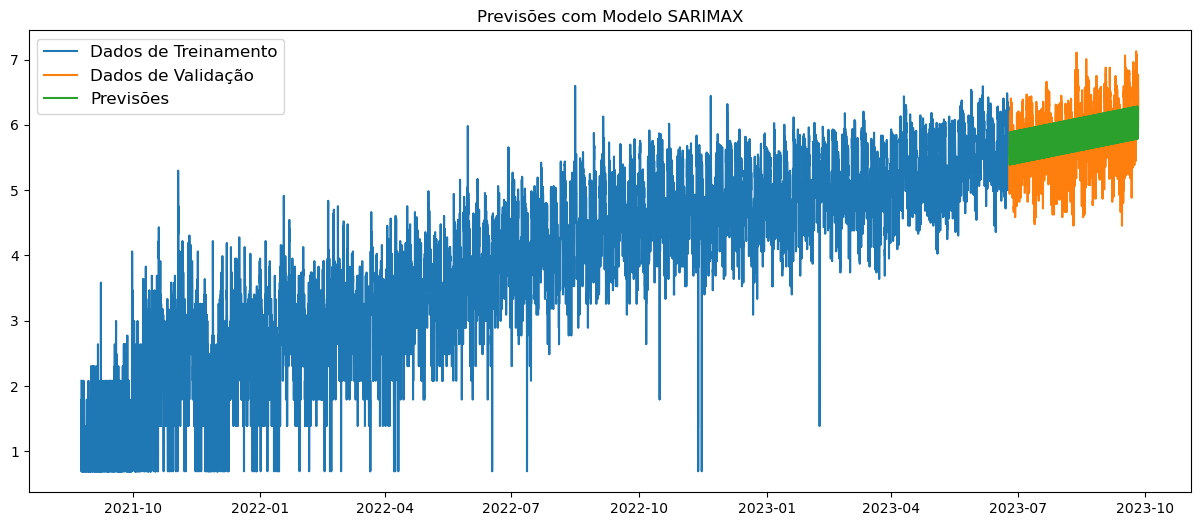

In [40]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [41]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [42]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [43]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.4634346612036791


Chegamos à melhor versão do nosso modelo. Vamos usá-lo para fazer as previsões com novos dados.

## Previsões com Novos Dados

In [44]:
df_dsa_novos_dados.head()

,id,data
data,,
2023-09-26 00:00:00,18288,2023-09-26 00:00:00
2023-09-26 01:00:00,18289,2023-09-26 01:00:00
2023-09-26 02:00:00,18290,2023-09-26 02:00:00
2023-09-26 03:00:00,18291,2023-09-26 03:00:00
2023-09-26 04:00:00,18292,2023-09-26 04:00:00


In [45]:
# Vamos fazer a previsão para uma janela de 30 horas
previsoes = modelo_v4.predict(start = df_dsa_novos_dados.data[0], 
                              end = df_dsa_novos_dados.data[30], 
                              dynamic = False)

In [46]:
type(previsoes)

pandas.core.series.Series

In [47]:
previsoes[1:30]

2023-09-26 01:00:00    6.106434
2023-09-26 02:00:00    6.053912
2023-09-26 03:00:00    5.958851
2023-09-26 04:00:00    5.854575
2023-09-26 05:00:00    5.790920
2023-09-26 06:00:00    5.837234
2023-09-26 07:00:00    5.936057
2023-09-26 08:00:00    6.011433
2023-09-26 09:00:00    6.109165
2023-09-26 10:00:00    6.256591
2023-09-26 11:00:00    6.284654
2023-09-26 12:00:00    6.256249
2023-09-26 13:00:00    6.108586
2023-09-26 14:00:00    6.056063
2023-09-26 15:00:00    5.961003
2023-09-26 16:00:00    5.856727
2023-09-26 17:00:00    5.793071
2023-09-26 18:00:00    5.839386
2023-09-26 19:00:00    5.938209
2023-09-26 20:00:00    6.013584
2023-09-26 21:00:00    6.111316
2023-09-26 22:00:00    6.258743
2023-09-26 23:00:00    6.286806
2023-09-27 00:00:00    6.258401
2023-09-27 01:00:00    6.110737
2023-09-27 02:00:00    6.058215
2023-09-27 03:00:00    5.963155
2023-09-27 04:00:00    5.858878
2023-09-27 05:00:00    5.795223
Freq: H, Name: predicted_mean, dtype: float64

Como o modelo foi treinado com dados que receberam transformação de log, precisamos calcular a inversa da transformação para extrair as previsões na mesma unidade da série temporal.

In [48]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2023-09-26 01:00:00    448.735587
2023-09-26 02:00:00    425.775226
2023-09-26 03:00:00    387.165195
2023-09-26 04:00:00    348.826562
2023-09-26 05:00:00    327.313923
2023-09-26 06:00:00    342.829912
2023-09-26 07:00:00    378.439725
2023-09-26 08:00:00    408.067567
2023-09-26 09:00:00    449.962722
2023-09-26 10:00:00    521.438549
2023-09-26 11:00:00    536.278751
2023-09-26 12:00:00    521.259904
2023-09-26 13:00:00    449.702183
2023-09-26 14:00:00    426.692364
2023-09-26 15:00:00    387.999166
2023-09-26 16:00:00    349.577949
2023-09-26 17:00:00    328.018971
2023-09-26 18:00:00    343.568382
2023-09-26 19:00:00    379.254901
2023-09-26 20:00:00    408.946563
2023-09-26 21:00:00    450.931961
2023-09-26 22:00:00    522.561751
2023-09-26 23:00:00    537.433919
2023-09-27 00:00:00    522.382721
2023-09-27 01:00:00    450.670861
2023-09-27 02:00:00    427.611478
2023-09-27 03:00:00    388.834933
2023-09-27 04:00:00    350.330956
2023-09-27 05:00:00    328.725539
Freq: H, Name:

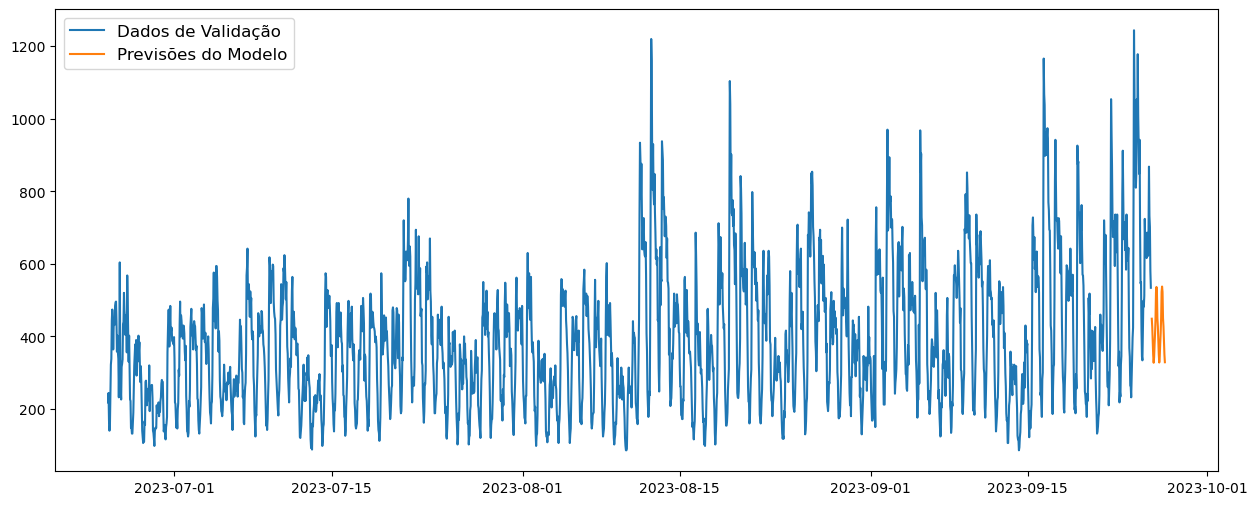

In [49]:
# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid, label = 'Dados de Validação')
plt.plot(np.exp(previsoes[1:30]), label = 'Previsões do Modelo')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [50]:
# Buscar as últimas 120 horas dos dados de validação
df_valid_ultimas_120_horas = df_valid.tail(120)

In [51]:
df_valid_ultimas_120_horas.head()

,usuarios_ativos
data,
2023-09-21 00:00:00,426
2023-09-21 01:00:00,288
2023-09-21 02:00:00,228
2023-09-21 03:00:00,190
2023-09-21 04:00:00,132


In [52]:
df_valid_ultimas_120_horas.tail()

,usuarios_ativos
data,
2023-09-25 19:00:00,868
2023-09-25 20:00:00,732
2023-09-25 21:00:00,702
2023-09-25 22:00:00,580
2023-09-25 23:00:00,534


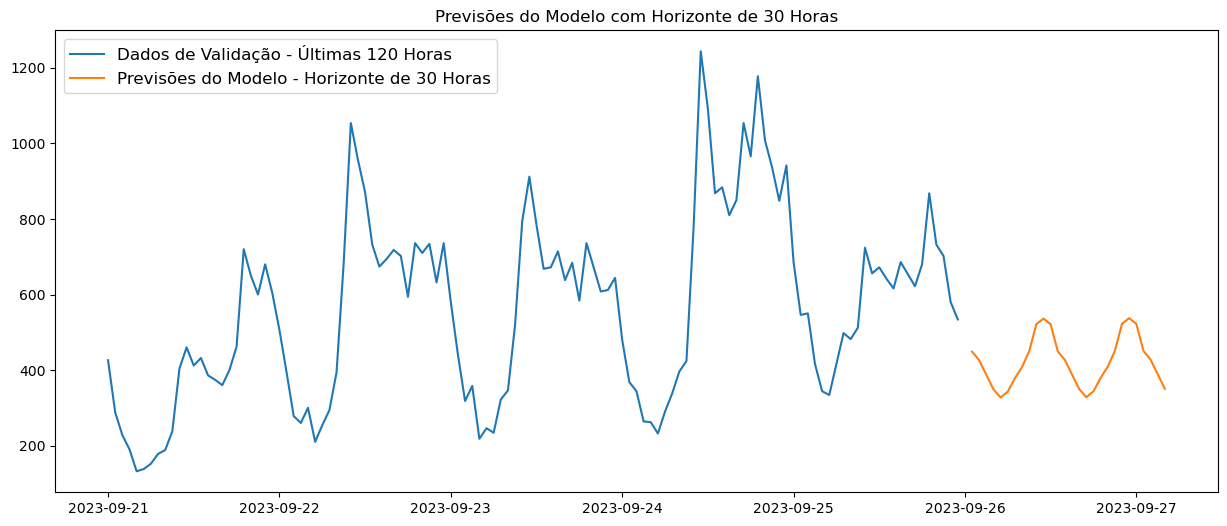

In [53]:
# Criamos uma nova série para as previsões com o índice correto
# O índice deve começar imediatamente após o último índice de df_valid_ultimas_120_horas
inicio_previsoes = df_valid_ultimas_120_horas.index[-1] + pd.Timedelta(hours = 1)
indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[1:30]), freq = 'H')
previsoes_series = pd.Series(np.exp(previsoes[1:30]), index = indice_previsoes)

# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid_ultimas_120_horas, label = 'Dados de Validação - Últimas 120 Horas')
plt.plot(previsoes_series, label='Previsões do Modelo - Horizonte de 30 Horas')
plt.title('Previsões do Modelo com Horizonte de 30 Horas')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show();

Busque um novo conjunto de dados, aplique as técnicas que ensinamos a você neste capítulo e pratique tudo que foi estudado.

In [54]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [55]:
#%watermark -v -m

In [56]:
#%watermark --iversions

# Fim